# Hypothesis

In short, we hypothesize that augmentation consistency of images will fall into 3 categories:
1. **Seen-before** tree species: High Consistency
2. **Not Seen-before** tree species: Medium Consistency
3. **Not Seen-before & Dissimilar** tree species: Low Consistency
    1. We also test on non-tree images for this category

Below is a table summarizing the expected consistency of the datasets.

| Dataset                     | Trained On | Same Species | Same Plot | Expected Consistency Rank |
|-----------------------------|------------|--------------|-----------|---------------------------|
| Train                       | Yes        | Yes          | Yes       | 1                         |
| Validation                  | No         | Yes          | Yes       | 2                         |
| Test                        | No         | Yes          | Yes       | 2                         |
| Casuarina (Same Species)    | No         | Yes          | No        | 3                         |
| Casuarina (Similar Species) | No         | No           | No        | 4                         |
| Casuarina (Diff Species)    | No         | No           | No        | 5                         |
| Non-Trees                   | No         | No           | No        | 6                         |


# Preparing the data

These are the datasets we'll be using:
- Chestnut @ 18th December 2020 **Train**
- Chestnut @ 10th May 2021 (43m) **Validation**
- Chestnut @ 10th May 2021 (60m) **Test**
- Casuarina **(Same/Similar/Different)**

Let's start by loading only the train dataset, we'll circle back to the other datasets later.

In [1]:
from math import ceil

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
from torch import kl_div
from torch.nn.functional import cross_entropy
from torch.utils.data import Dataset
from torchvision.transforms.v2 import Compose, RandomCrop, \
    RandomHorizontalFlip, RandomVerticalFlip, RandomRotation, RandomApply, \
    ToImage, ToDtype, Resize, RandomErasing
from tqdm import tqdm

from frdc.load.preset import FRDCDatasetPreset as ds
from frdc.models.inceptionv3 import InceptionV3MixMatchModule


In [2]:
ds_train = ds.chestnut_20201218()
ds_casuarina = ds.casuarina_20220418_93deg()

To start, we'll construct a function to plot a grid of samples.

In [3]:
def plot_samples(samples: list[tuple[np.ndarray, str]],
                 title: str,
                 rows: int, ):
    """Plot a grid of samples with their targets."""
    fig, axs = plt.subplots(rows, ceil(len(samples) / rows),
                            figsize=(10, rows * 2))
    for (im_bgr, tgt), ax in zip(samples, axs.flatten()):
        im_rgb = np.nan_to_num(im_bgr[..., [2, 1, 0]]).astype(int)
        ax.imshow(im_rgb)
        ax.set_title(f"{tgt}")
        ax.axis("off")
    fig.suptitle(title)
    fig.tight_layout()
    plt.show()

Let's plot some samples from the train dataset.

> We use a `zip` to limit the number of samples to the number of rows.
> This works by prematurely stopping the iteration when `range(n_samples)` is exhausted.
> This will thus also stop the `ds_train` iteration.

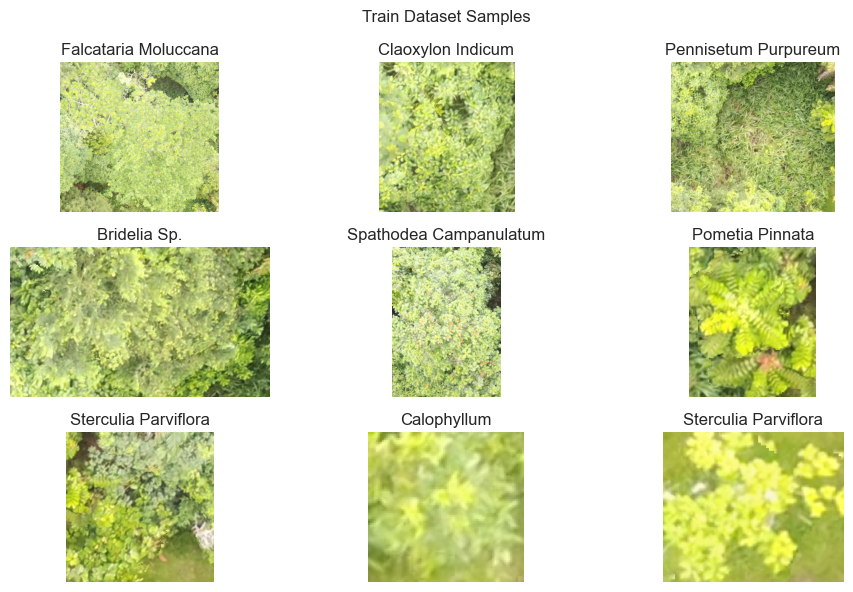

In [4]:
n_samples = 9
plot_samples(
    [(im, tgt) for _, (im, tgt) in
     zip(range(n_samples), ds_train)],
    "Train Dataset Samples",
    rows=3,
)

Recall that for Label Studio, the trees are cropped via a polygon.
However, to simplify things, we will use the full smallest bounding box that contains the polygon.

We kind of get the idea of Chestnut Nature Park trees, let's skip to the Casuarina dataset.

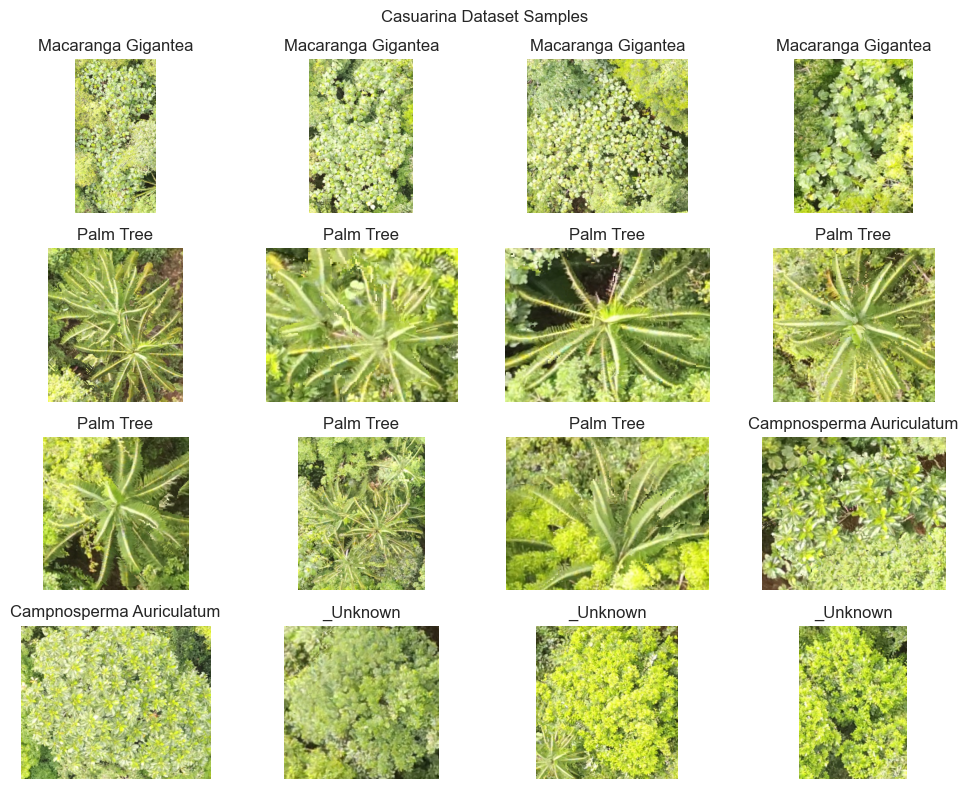

In [5]:
n_samples = 16
plot_samples(
    [(im, tgt) for _, (im, tgt) in
     zip(range(n_samples), ds_casuarina)],
    "Casuarina Dataset Samples",
    rows=4,
)

As observed, we do have a separate plethora of tree species in the Casuarina dataset.
The key is that the model has also seen **Campnosperma Auriculatum**,
however, never seen **Macaranga Gigantea** nor **Palm Tree**.
Furthermore, we have some other trees unlabeled.

By eye, we see that **Macaranga**, despite not seen before, is similar to trees in the Chestnut dataset.
While **Palm Tree** is not similar to any trees in the Chestnut dataset.

That said, we can expect the following consistency:

| Tree Species             | Expected Consistency Rank |
|--------------------------|---------------------------|
| Campnosperma Auriculatum | 1                         |
| Macaranga Gigantea       | 2                         |
| Palm Tree                | 3                         |
 

# Model

Before we proceed, let's load the model we used for training.

This model is
- trained only on the Chestnut 18th December 2020 dataset
- validated on the Chestnut 10th May 2021 (43m) dataset
- tested on the Chestnut 10th May 2021 (60m) dataset
- never seen the Casuarina dataset

In [6]:
m: InceptionV3MixMatchModule = InceptionV3MixMatchModule.load_from_checkpoint(
    "model.ckpt").eval()

As a recap, our adapted InceptionV3 Model changes the following:
1. The first layer is changed to accept 8 channels
2. The last layer is replaced to output K classes

In [7]:
print("Adapted First Layer")
print(m.inception.Conv2d_1a_3x3)
print("\nAdapted Last Layer")
print(m.fc)

Adapted First Layer
BasicConv2d(
  (conv): Conv2d(8, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
  (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
)

Adapted Last Layer
Sequential(
  (0): Linear(in_features=2048, out_features=682, bias=True)
  (1): BatchNorm1d(682, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): Linear(in_features=682, out_features=19, bias=True)
  (3): Softmax(dim=1)
)


# Evaluating Consistency

To evaluate the consistency, we need to define a function that:
1. Takes in a dataset
2. For each image, it will:
    1. Augment the image `n` times
    2. Pass the augmented images through the model
    3. Compute the consistency of the predictions
3. Return the consistency of the dataset

Firstly, let's define the augmentation function.

## Augmentation

> The augment is the same as the one used for training.

This augmentation is quite simple, a random crop, flips and rotations.
Generally, these augmentations are considered **weak**, as they generate samples very likely to have been taken instead.  

In [8]:


def preprocess(x):
    return Compose(
        [
            ToImage(),
            ToDtype(torch.float32),
            Resize(
                InceptionV3MixMatchModule.MIN_SIZE,
                antialias=False,
            ),
            RandomCrop(
                InceptionV3MixMatchModule.MIN_SIZE,
                pad_if_needed=False,
            ),
            RandomHorizontalFlip(),
            RandomVerticalFlip(),
            RandomApply([RandomRotation((90, 90))], p=0.5),
            RandomErasing(
                p=0.5,
                scale=(0.02, 0.33),
                ratio=(0.3, 3.3),
                value=np.nan
            ),
        ]
    )(x)


As mentioned above, we only loaded the train dataset. This is because we will now apply the augmentations

In [9]:
ds_train_aug = ds.chestnut_20201218(transform=preprocess)

## Looping through the dataset

We will loop through the dataset, which has our augmentation function applied.

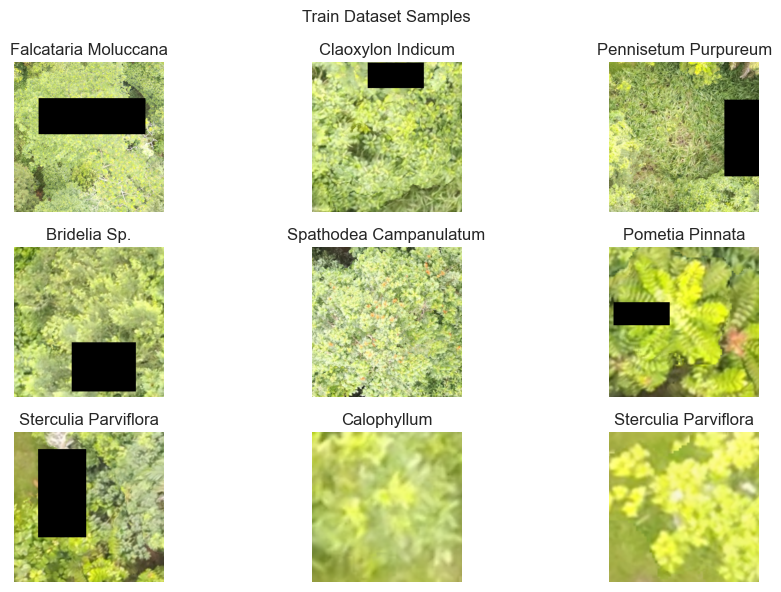

In [10]:
n_samples = 9
plot_samples(
    [(im.permute(1, 2, 0), tgt) for _, (im, tgt) in
     zip(range(n_samples), ds_train_aug)],
    "Train Dataset Samples",
    rows=3,
)

As a quick check, we re-run the augmentation function to see if the images augmented randomly 

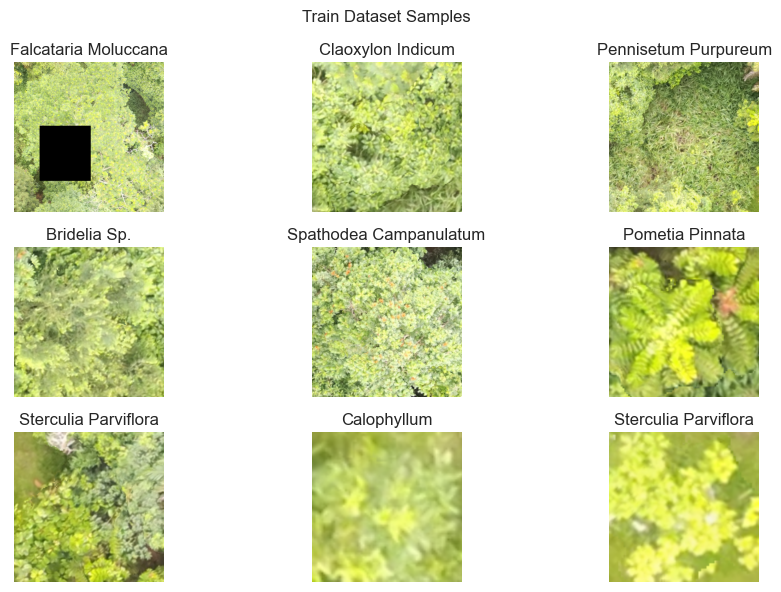

In [11]:
plot_samples(
    [(im.permute(1, 2, 0), tgt) for _, (im, tgt) in
     zip(range(n_samples), ds_train_aug)],
    "Train Dataset Samples",
    rows=3,
)

Finally, we need some custom preprocessing to match the model's input.

In [12]:
def x_preprocess(x):
    b, c, h, w = x.shape
    x_ss = m.x_scaler.transform(
        x.permute(0, 2, 3, 1).reshape(-1, c)
    )
    return torch.nan_to_num(
        torch.from_numpy(x_ss.reshape(b, h, w, c))
        .permute(0, 3, 1, 2)
        .float()
    )

Here, we loop through the dataset repeatedly, and store the predictions.
These will be then used to calculate the Jensen-Shannon Divergence.

In [13]:
y_preds = []
y_tgt = []
iterations = 20
for i in tqdm(range(iterations), desc="Iterations"):
    y_batch_pred = m(x_preprocess(
        torch.stack([im for im, tgt in ds_train_aug])).cuda()).detach().cpu()
    y_preds.append(y_batch_pred)

y_tgt = [tgt for im, tgt in ds_train_aug]
y_pred = torch.stack(y_preds)

Iterations: 100%|██████████| 20/20 [00:05<00:00,  3.53it/s]


To measure the consistency, we can utilize the Jensen-Shannon Divergence.

Note that generally, the Jensen-Shannon Divergence is used to measure the similarity between two probability distributions.

$$
JSD(P, Q) = \frac{1}{2} D_{KL}(P || M) + \frac{1}{2} D_{KL}(Q || M)
$$

Where $M = \frac{1}{2} (P + Q)$

However, it's also possible to extend this to multiple probability distributions.
$$
JSD(P_1, P_2, \ldots, P_n) = \frac{1}{n} \sum_{i=1}^{n} D_{KL}(P_i || M)
$$


Getting the Mixture Distribution is quite simple.

1) We prepare `js_p` to have the sample dimension in-front (i.e. each sample is a row), so we can iterate through it easily later.
2) We calculate the mean of the predictions across the iterations, which is the mixture distribution.

In [14]:
js_p = y_pred.permute(1, 0, 2)
js_q = y_pred.mean(dim=0)
print(js_p.shape, js_q.shape)

torch.Size([32, 20, 19]) torch.Size([32, 19])


The above shapes:
- `js_p` is $(\text{Samples}, \text{Iterations}, \text{Classes})$
- `js_q` is $(\text{Samples}, \text{Classes})$

*To keep it simple, we'll avoid trying to vectorize the computation.*

Now, we calculate the Jensen-Shannon Divergence.

1) We iterate through the samples, `js_p_i` is the predictions for the $i$-th sample.
2) We calculate the KL Divergence between the $i$-th sample and the mixture distribution.
3) `jsd` is the Jensen-Shannon Divergence for each sample. Note that the Divergence is a vector, not a scalar. This is because each distribution is compared against the mixture distribution. Therefore `jsd` is of shape $\text{Samples} \times \text{Iterations}$.
4) We then sort the JSD for better visualization. (This is because iteration order doesn't matter)

In [17]:
jsd = []
for js_p_i, js_q_i in zip(js_p, js_q):
    jsd_i = torch.stack([
        kl_div(torch.log(d), js_q_i) for d in js_p_i
    ]).mean(
        dim=1)
    jsd.append(jsd_i)

jsd = torch.stack(jsd).detach().numpy()
df_jsd = pd.DataFrame(jsd, index=y_tgt)
# Sorted JSD
df_jsd[:] = np.sort(df_jsd.values, axis=1)[:, ::-1]

At this point, `jsd` is actually a matrix of $\text{Samples} \times \text{Iterations}$.
We can visualize this as a heatmap.

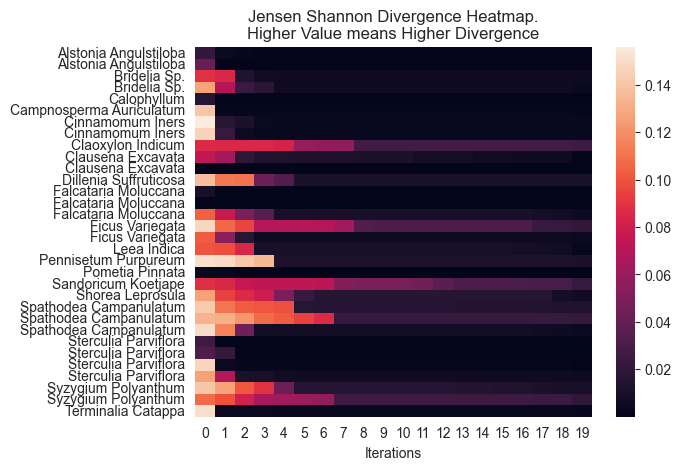

In [18]:
ax = sns.heatmap(df_jsd.sort_index(), yticklabels=True)
ax.set_title(
    "Jensen Shannon Divergence Heatmap.\nHigher Value means Higher Divergence")
_ = ax.set_xlabel("Iterations")

As shown above, we can clearly see some samples are more divergent than others.

# Results

Now, we'll wrap the above into a function and apply it to the other datasets.

> We also get the Cross Entropy as a means of measuring accuracy.

In [114]:
def get_jsd(m, ds, iterations=100, calculate_ce: bool = False) -> tuple[
    pd.DataFrame, pd.DataFrame | None
]:
    y_pred = []
    for _ in tqdm(range(iterations), desc="Iterations"):
        y_batch_pred = m(x_preprocess(
            torch.stack([im for im, tgt in ds])).cuda()).detach().cpu()
        y_pred.append(y_batch_pred)

    y_tgt = [tgt for im, tgt in ds]
    y_pred = torch.stack(y_pred)
    js_p = y_pred.permute(1, 0, 2)
    js_q = y_pred.mean(dim=0)
    jsd = []
    for js_p_i, js_q_i in zip(js_p, js_q):
        a = torch.stack([kl_div(torch.log(d + 1e-10), js_q_i) for d in js_p_i]).mean(
            dim=1)
        jsd.append(a)

    jsd = torch.stack(jsd).detach().numpy()
    df_jsd = pd.DataFrame(jsd, index=y_tgt)
    df_jsd_median_order = df_jsd.median(axis=1).argsort()
    df_jsd = df_jsd.iloc[df_jsd_median_order]
    df_ce = None
    if calculate_ce:
        # This is unfortunately quite verbose
        y_tgt_enc = torch.tensor(
            m.y_encoder.transform(
                np.array(y_tgt).reshape(-1, 1)
            ).squeeze()
        )
        y_pred_mean = y_pred.mean(dim=0)

        # Some targets are never seen by the y_encoder, they will be NaN
        # As a hacky way to get around this, we just set them to the first target.
        y_tgt_enc = torch.nan_to_num(y_tgt_enc, nan=0).long()

        # By default, the reduction is "mean", we want "none" to get the per-sample CE
        y_ce = cross_entropy(y_pred_mean, y_tgt_enc, reduction="none")

        df_ce = pd.DataFrame(y_ce.detach().numpy(), index=y_tgt)
        df_ce = df_ce.iloc[df_jsd_median_order]

    return df_jsd, df_ce

We also construct some handy plotting functions.

In [53]:
def plot_jsd_heatmap(df: pd.DataFrame, figsize=(3, 5)):
    # This sorts the rows (iterations) independently
    df[:] = np.sort(df.values, axis=1)[..., ::-1]

    # seaborn somehow reverses the y-axis, so we reverse the dataframe
    ax = sns.heatmap(df[::-1], yticklabels=True, vmin=0, vmax=1,
                     xticklabels=False)

    ax.set_title(
        "Jensen Shannon Divergence Heatmap.\nLower Value is better")
    ax.set_xlabel("Iterations")
    plt.gcf().set_size_inches(*figsize)
    plt.show()

In [54]:
def plot_jsd_median_hbar(df: pd.DataFrame, figsize=(3, 5), xlim=(0, 0.5)):
    df.median(axis=1).plot(kind="barh")

    plt.title(
        "Jensen Shannon Divergence Median.\nLower Value is better")
    plt.xlim(*xlim)
    plt.gcf().set_size_inches(*figsize)
    plt.show()

In [55]:
def plot_ce_hbar(df: pd.DataFrame, figsize=(5, 5)):
    df.plot(kind="barh")

    plt.title(
        "Cross Entropy Median.\nLower Value is better")
    plt.legend().remove()
    plt.gcf().set_size_inches(*figsize)
    plt.tight_layout()
    plt.show()

## Train Dataset Results
We'll start by evaluating the train dataset.

In [56]:
df_train_jsd, df_train_ce = get_jsd(m, ds_train_aug, calculate_ce=True)

Iterations: 100%|██████████| 100/100 [00:30<00:00,  3.32it/s]


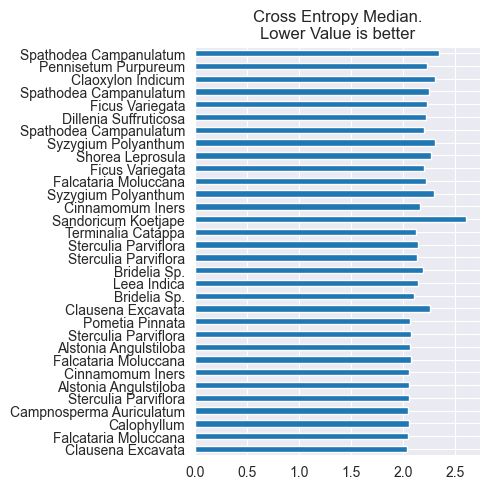

In [57]:
plot_ce_hbar(df_train_ce)

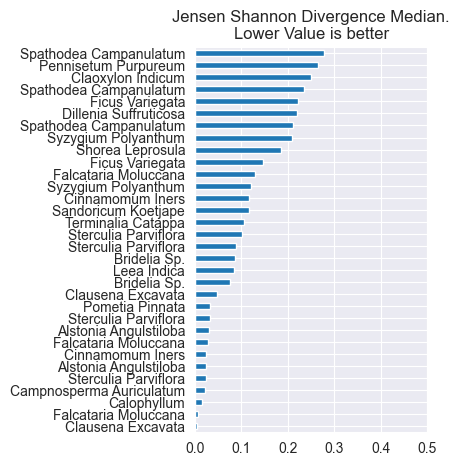

In [58]:
plot_jsd_median_hbar(df_train_jsd)

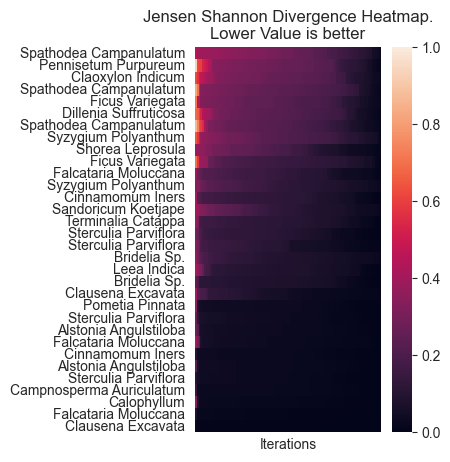

In [59]:
plot_jsd_heatmap(df_train_jsd)

### Train Dataset Discussion

We see that the Cross Entropy aligning with the Divergence makes sense, as lower divergence logically correlates with higher accuracy. However, this isn't all, as this is only the train dataset.

## Validation Dataset Results

In [60]:
ds_val_aug = ds.chestnut_20210510_43m(transform=preprocess)

In [61]:
df_val_jsd, df_val_ce = get_jsd(m, ds_val_aug, calculate_ce=True)

Iterations: 100%|██████████| 100/100 [00:30<00:00,  3.24it/s]


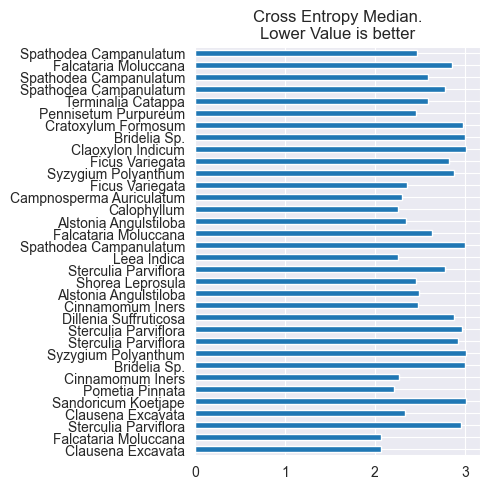

In [62]:
plot_ce_hbar(df_val_ce)

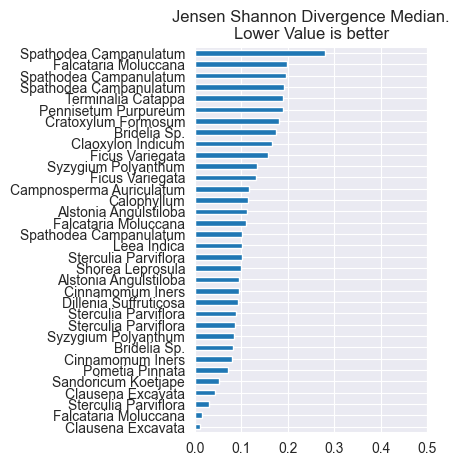

In [63]:
plot_jsd_median_hbar(df_val_jsd)

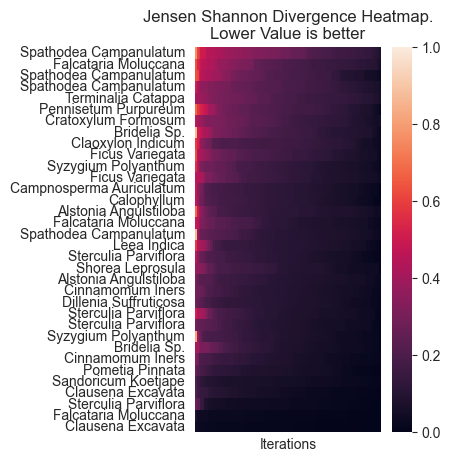

In [64]:
plot_jsd_heatmap(df_val_jsd)

### Validation Dataset Discussion

In a surprising turn of events, the divergence is actually lower than the train dataset.
This is quite unexpected, as the model has never seen the validation dataset, yet managed to 
perform better.

In [65]:
ds_casuarina_jsd = ds.casuarina_20220418_93deg(transform=preprocess)
df_casuarina_jsd, _ = get_jsd(m, ds_casuarina_jsd)

Iterations: 100%|██████████| 100/100 [01:24<00:00,  1.19it/s]


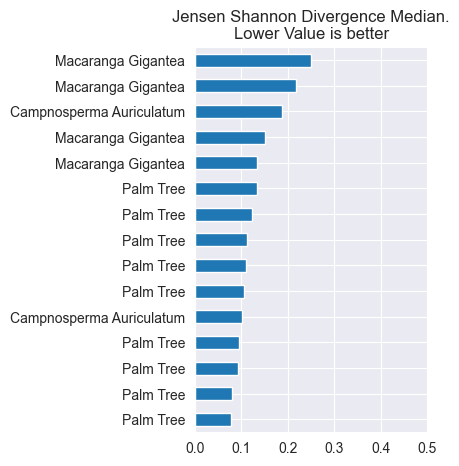

In [66]:
# Get all samples not "_Unknown"
plot_jsd_median_hbar(df_casuarina_jsd[df_casuarina_jsd.index != "_Unknown"])

C:\Users\CH0002HN\AppData\Local\Temp\ipykernel_10500\3394045222.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[:] = np.sort(df.values, axis=1)[..., ::-1]
C:\Users\CH0002HN\AppData\Local\Temp\ipykernel_10500\3394045222.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[:] = np.sort(df.values, axis=1)[..., ::-1]


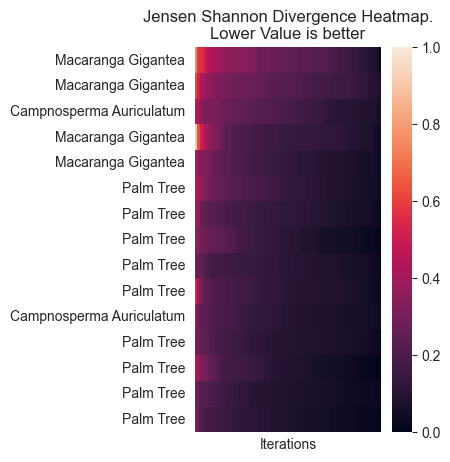

In [67]:
plot_jsd_heatmap(df_casuarina_jsd.loc[df_casuarina_jsd.index != "_Unknown"])

Finally, we want to test it against a noise dataset.
However, note that the noise generated must be to scale with the images.
We'll check the minimum and maximum values the chestnut dataset and generate noise within that range.

In [92]:
chn_min = torch.tensor(
    [np.nanmin(ds_train.ar[..., c]) for c in
     range(ds_train.ar.shape[-1])]).reshape(8, 1, 1)
chn_max = torch.tensor(
    [np.nanmax(ds_train.ar[..., c]) for c in
     range(ds_train.ar.shape[-1])]).reshape(8, 1, 1)

In [69]:
# Create a noise dataset


class NoiseDataset(Dataset):
    def __init__(self, size: int, transform=None):
        self.size = size
        self.transform = transform

    def __len__(self):
        return self.size

    def __getitem__(self, idx):
        if idx >= self.size:
            raise IndexError
        # Based on the noise_min and noise_max
        x = torch.rand(8, 299, 299) * (chn_max - chn_min) + chn_min
        if self.transform:
            x = self.transform(x)
        return x, 0


ds_noise = NoiseDataset(25, transform=preprocess)

In [70]:
df_noise_jsd, _ = get_jsd(m, ds_noise)

Iterations: 100%|██████████| 100/100 [00:26<00:00,  3.73it/s]


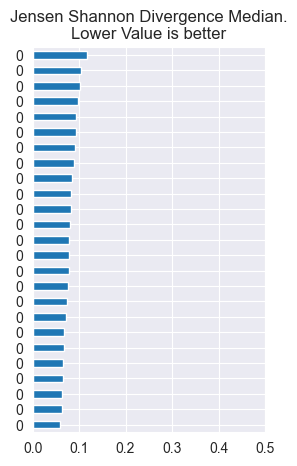

In [71]:
plot_jsd_median_hbar(df_noise_jsd)

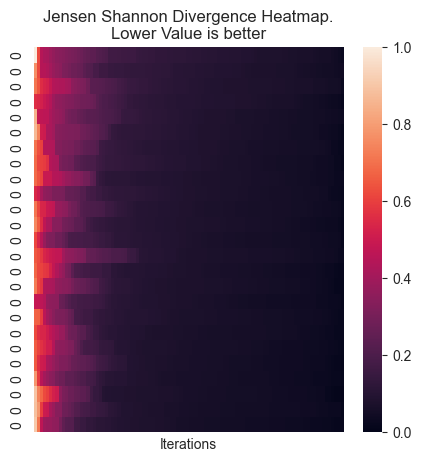

In [72]:
plot_jsd_heatmap(df_noise_jsd, figsize=(5, 5))

In [99]:
from torchvision.datasets import CIFAR10
from PIL import Image


class CIFAR10Extended(CIFAR10):
    def __len__(self):
        return 100

    def __getitem__(self, index: int):
        """
        Args:
            index (int): Index

        Returns:
            tuple: (image, target) where target is index of the target class.
        """

        if index >= 100:
            raise IndexError
        img, target = self.data[index], self.targets[index]

        # doing this so that it is consistent with all other datasets
        # to return a PIL Image
        img = Image.fromarray(img)

        # Repeat the green channel for 5 more times and append to the img
        img = np.concatenate(
            [np.array(img), np.repeat(np.array(img)[:, :, 1:2], 5, axis=2)],
            axis=2)

        # Scale by noise
        img = (img / 256) * (
                    chn_max.numpy().reshape(1, 1, 8) - chn_min.numpy().reshape(
                1, 1, 8)) + chn_min.numpy().reshape(1, 1, 8)

        if self.transform is not None:
            img = self.transform(img)

        if self.target_transform is not None:
            target = self.target_transform(target)

        return img, target

In [100]:
ds = CIFAR10Extended(root="data", download=False, transform=preprocess, )

In [115]:
df_cifar10_jsd, _ = get_jsd(m, ds)

Iterations: 100%|██████████| 100/100 [01:12<00:00,  1.39it/s]


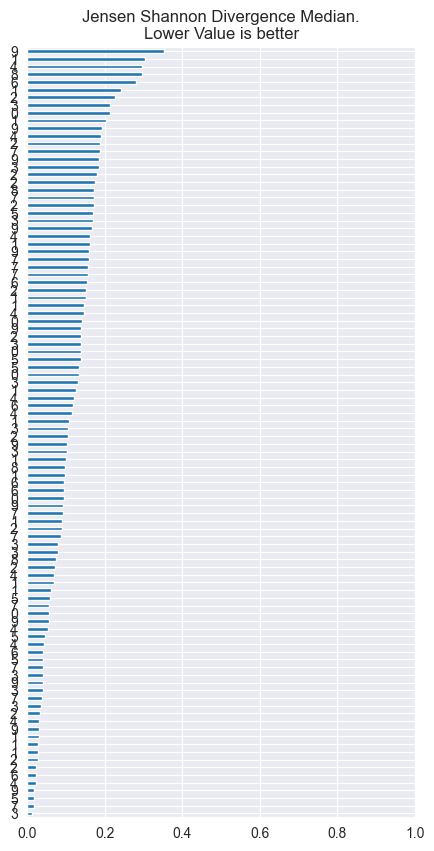

In [118]:
plot_jsd_median_hbar(df_cifar10_jsd, figsize=(5, 10), xlim=(0, 1))

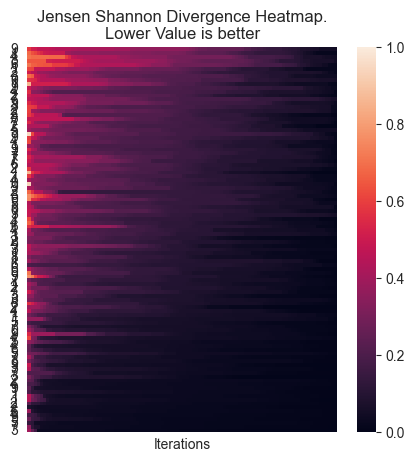

In [119]:
plot_jsd_heatmap(df_cifar10_jsd, figsize=(5, 5))